In [2]:
# pip install photutils
# pip install astropy

In [3]:
# Import all modules needed for this notebook

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [4]:
# Set path to file
# This exposure was taken in the B-band. 
file_input   = '/Users/jielaizhang/Desktop/waissya/WAISSYA_LCO/Target_F/V/cpt0m407-kb84-20191029-0188-e91.fits.fz'
mypath       = '/Users/jielaizhang/Desktop/waissya/WAISSYA_LCO/Target_A/V/' 

# Details on target and reference stars

In [5]:
# Identify the star that you wanted to observe by opening the image in ds9 
# by finding the star with the matching RA and DEC
# Write down the RA and DEC of your target star here
# Check that the star is not saturated (Using ds9)

target_RA  = 42.54127
target_DEC = -26.26448

In [6]:
# By looking at one of the exposures in ds9, identify 4-5 round, 
# bright stars that are not saturated 
# to use as ref stars.
# Write down their RA, DEC below in a list

ref_ra  = [42.511006, 42.516465, 42.529286,  42.570479,  42.607145]
ref_dec = [-26.234616,-26.204686,-26.250919, -26.411994,-26.369884]

In [20]:
# Download the APASS catalog of this region of the sky from here: 
# https://www.aavso.org/apass-dr10-download
# Identify which sources on the APASS catalog match the RA and DEC of your selected 
# reference stars
# Write down the magnitude of your selected reference stars below in a list

ref_mag_B = [13.151,12.349,13.298,12.865,14.052]
ref_mag_V = [12.122,11.815,12.504,12.198,13.299]
ref_mag = ref_mag_V

# Visualize image, target and refernece stars

### Visualize a simple "image"

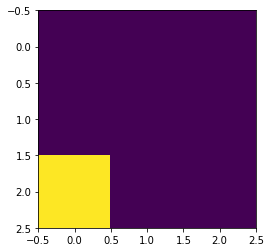

In [21]:
simple_image = [[1.,2.,1.3],[1.9,2.3,1.8],[1000,2.1,1.4]]
plt.imshow(simple_image)

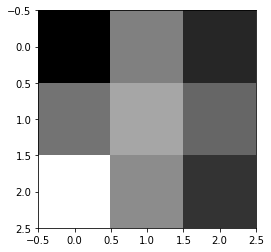

In [22]:
simple_image = [[1.,  2., 1.3],
                [1.9, 2.3,1.8],
                [1000,2.1,1.4]]

plt.imshow(simple_image,vmin=1, vmax=3, cmap='gray')

### Visualize our single frame

vmin:  -53.962704
vmax:  85.82354


Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1456.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


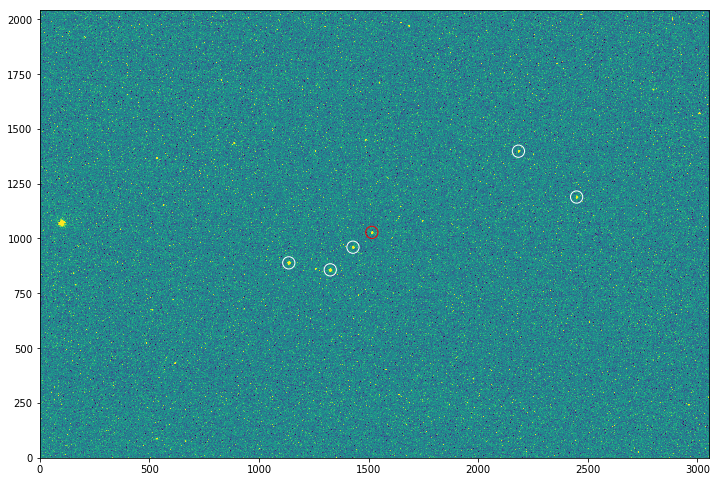

In [23]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data
hdu = fits.open(file_input)
sci_data = hdu[1]
sci_hdr = sci_data.header

# Determine where to mark the reference stars
w = wcs.WCS(sci_hdr)
xcoord_ref, ycoord_ref = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
# See why these two values were picked using ds9. 
interval = ZScaleInterval()
vmin = interval.get_limits(sci_data.data)[0]
vmax = interval.get_limits(sci_data.data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
plt.imshow(sci_data.data, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Some useful functions

In [24]:
# A function that outputs the magnitude of a source, and its error.

def do_phot_get_mag(data,hdr,err,ra,dec):
    zpt_instrumental = 25.
    w         = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot      = aperture_photometry(data, apertures, error=err)

    mag     = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err

In [25]:
# A function that outputs a small cutout of an image given a big image. 

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

# Try to calcualte the magnitude of the target star in one frame. 

### 1. Open the frame and read out the data, header and time of observation

In [26]:
# Read in file
hdu = fits.open(file_input)

# Grab the actual science data based on above.
sci_data = hdu[1]
sci_hdr = sci_data.header
time = sci_hdr['MJD-OBS']

### Exercise

In [27]:
# Print the time of observation of this exposure


### 2. Get the background of the image and subtract it; Calculate the error associated with the background.

In [28]:
# Background estimation:
sigma_clip = SigmaClip(sigma=2.5) # Sigma clip bright obvious things to avoid biasing the background estimate
bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
bkg = Background2D(
    sci_data.data, (300, 300),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator)

# Now let's subtract the background from the data
sci_bkg = sci_data.data - bkg.background

# Define an error image that will be used when calculating photometry
effective_gain = 1.
error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

vmin:  10.794535931147124
vmax:  11.739704007918107


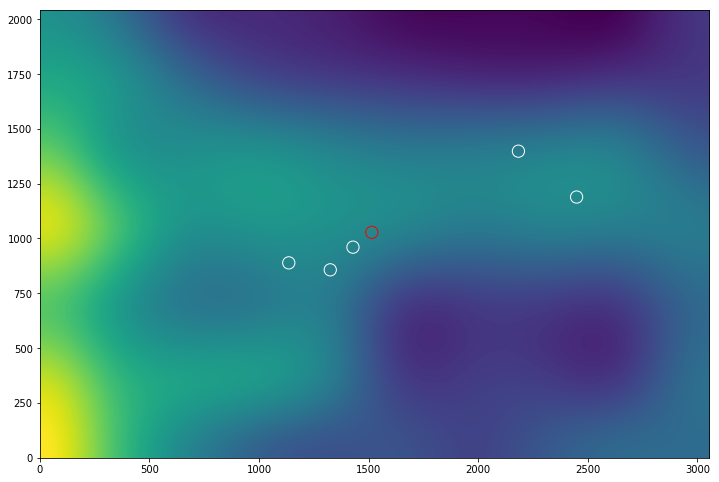

In [29]:
# Show the background to see what it looks like

interval = ZScaleInterval()
vmin = interval.get_limits(bkg.background)[0]
vmax = interval.get_limits(bkg.background)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
plt.imshow(bkg.background, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

### Exercise

vmin:  -65.03024911341116
vmax:  74.77058574371306


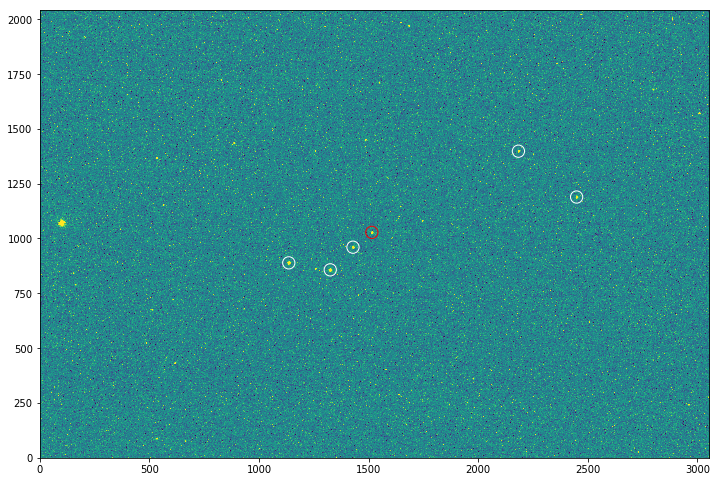

In [30]:
# Show the background subtracted image and see what it looks like

# Show the background to see what it looks like

interval = ZScaleInterval()
vmin = interval.get_limits(sci_bkg)[0]
vmax = interval.get_limits(sci_bkg)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

### 3. For the target star and each reference star, carry out photometry. Be sure to use the background subtracted image. This step should output an error of the photmetry measurement. 

In [31]:
# Calculate instrumental mags for each of the reference stars
ref_instr_mag,ref_instr_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

# Do photometry on the variable target
tar_mag,tar_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,target_RA,target_DEC)

Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1456.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


### 4. Find the magnitude offset between the reference stars and the catalog magnitudes and calculate the magnitude of the target star, and its error. 

In [32]:
# Calculate offsets and the standard deviation of the offset from each star.
offsets = []
for i in range(len(ref_instr_mag)):
    offsets.append(ref_mag[i] - ref_instr_mag[i])
offset = np.mean(offsets)
offset_err = np.std(offsets)

cal_tar_mag = tar_mag[0]+offset
cal_tar_mag_err = np.sqrt(tar_mag_err[0]**2.+offset_err**2.)

# Make a tiny cutout around the star

Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1456.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


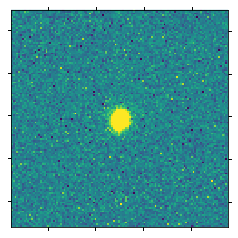

In [33]:
# Make tiny cutouts of the variable star in each frame
cutout_hdu = make_cutout(sci_bkg,sci_hdr,target_RA,target_DEC)
#cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)

# Plot figures using these cutouts and output images
interval = ZScaleInterval()
vmin = interval.get_limits(cutout_hdu.data)[0]
vmax = interval.get_limits(cutout_hdu.data)[1]

plt.subplot(projection=wcs.WCS(cutout_hdu.header))
plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
plt.xlabel('R.A.')
plt.ylabel('Declination')

# Save the small cutout as a png, with the file name as the time of observation. 
# This can be used later to make a movie of your source
pngname = str(time).replace('.','')
plt.savefig(mypath+pngname+'.png', overwrite=True)